In [1]:
# Cell 1: Imports and Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Make charts look professional
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (12, 6)

print("Workbench initialized.")

Workbench initialized.


In [2]:
# Cell 2: Robust Data Load
import os
import sys
import pandas as pd

# 1. DIAGNOSTICS: Where are we?
print(f"Notebook is running in: {os.getcwd()}")

# 2. FIND THE FILE (Try multiple common paths)
filename = "ewa_ewc_pairs.csv"
possible_paths = [
    f"data/{filename}",           # Standard structure
    f"../data/{filename}",        # If running from a subfolder
    f"kalman-quant-project/data/{filename}" # PyCharm specific weirdness
]

file_path = None
for path in possible_paths:
    if os.path.exists(path):
        file_path = path
        print(f"SUCCESS: Found data at {path}")
        break

# 3. LOAD OR FAIL
if file_path:
    # Load the data
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)

    # Define assets
    x_label = "EWA"
    y_label = "EWC"

    # Split data (This only runs if df exists, so no NameError!)
    train = df.loc['2019-01-01':'2019-12-31']
    test = df.loc['2020-01-01':'2020-12-31']

    print(f"Training Data: {len(train)} days")
    print(f"Testing Data: {len(test)} days")

else:
    # STOP EVERYTHING if file is missing
    print("\nCRITICAL ERROR: File not found in any standard location.")
    print("Please check that 'ewa_ewc_pairs.csv' is inside the 'data' folder.")
    # Raise an error to stop execution
    raise FileNotFoundError("Could not locate data file. Stopping.")

Notebook is running in: F:\QuantProject\kalman-quant-project
SUCCESS: Found data at data/ewa_ewc_pairs.csv
Training Data: 252 days
Testing Data: 253 days


# Phase 1: The Naive Strategy (the control group): Detailed Workflow & Logic

This section details the exact mechanics of the "Naive" (Static) Pairs Trading strategy. We use this as a baseline to demonstrate why static parameters fail during regime changes.

### Assumptions for this Example
* **Asset A ($Y$):** Canada (EWC)
* **Asset B ($X$):** Australia (EWA)
* **The Calculated Beta ($\beta$):** **0.80** (Derived from 2019 OLS data)

---

### Step 1: The Training (2019)
We run an OLS regression on 2019 price data.
* **The Math:** $Price_{Canada} = \beta \times Price_{Australia} + \text{Constant}$
* **The Result:** The model determines $\beta = 0.80$.
* **Physical Meaning:** "On average, 1 share of Canada behaves like 0.8 shares of Australia."
* **The Hedge Rule:** To be neutral (safe), for every **1 share of Canada** you hold, you must be Short **0.8 shares of Australia**.

---

### Step 2: The Testing Setup (2020)
We enter the 2020 testing period. We treat the **Beta (0.80)** as a fixed law. We construct a "Virtual Portfolio" called **The Spread**.
* **Equation:**
    $$Spread_t = Price_{Canada, t} - (0.80 \times Price_{Australia, t})$$

**Visualizing the Spread:**
* If Canada is **\$30.00** and Australia is **\$25.00**:
* Calculation: $30.00 - (0.80 \times 25.00) = 30 - 20 = \textbf{\$10.00}$.
* This **\$10.00** is the "baseline price" of our portfolio.

---

### Step 3: The Signal (Z-Score)
Assume it is **Day 30** of 2020.
* We calculate the average spread of the last 30 days. Assume Mean = **\$10.00**.
* We calculate the standard deviation. Assume Std Dev = **\$0.50**.

**Today's Market Movement:**
The market gets weird. Canada jumps to **\$32.00**, but Australia stays at **\$25.00**.
* **New Spread Value:** $32 - (0.8 \times 25) = \textbf{\$12.00}$.

**Calculate Z-Score:**
$$Z = \frac{\text{Current} - \text{Mean}}{\text{StdDev}} = \frac{12.00 - 10.00}{0.50} = \frac{2.00}{0.50} = \textbf{+4.0}$$

**The Logic:** A Z-Score of +4 is huge. It means the Spread is **expensive** (Canada is overpriced relative to Australia).
* **Signal:** **-1** (Short the Spread).

---

### Step 4: The Execution (Position Sizing)
**The Rule:** We always trade in units of **1 Spread**.
* **1 Unit of Spread** = **1 Share of Canada** and **-0.8 Shares of Australia**.

**Scenario: Signal is -1 (Short the Spread)**
To "Short" this portfolio, we do the **exact opposite** of the definition:
* **SELL** 1 Share of Canada.
* **BUY** 0.8 Shares of Australia.
* *(Note: In a real account, you scale this ratio up, e.g., Sell 1,000 Canada / Buy 800 Australia).*

**Scenario: Signal is +1 (Long the Spread)**
If Z-Score was $<-2$ (Spread is cheap), we would:
* **BUY** 1 Share of Canada.
* **SELL** 0.8 Shares of Australia.

---

### Step 5: Daily PnL Examples (The Math)
Assume we are **Short the Spread** (Signal = -1).
* **Position:** Short 1 Canada, Long 0.8 Australia.
* **Objective:** We want the Spread value to go **DOWN** (back to \$10.00).

#### Example A: The Happy Profit (Convergence)
The next day, prices return to normal.
* **Canada:** Drops \$32.00 $\to$ \$30.00 (Change: **-\$2.00**).
* **Australia:** Flat at \$25.00 (Change: **\$0.00**).

**PnL Calculation:**
1.  **Short Canada:** Sold at \$32, buy back at \$30. Profit = **+\$2.00**.
2.  **Long 0.8 Australia:** No move. Profit = **\$0.00**.
3.  **Total PnL:** $+\$2.00$.
* *Verification:* The Spread went from \$12.00 down to \$10.00. We shorted at \$12, covered at \$10. **Success.**

#### Example B: The Relative Win (Both go UP)
The market rallies, but Australia rallies *harder* (The Hedge works).
* **Canada:** Goes UP \$32.00 $\to$ \$33.00 (Change: **+\$1.00**).
* **Australia:** Goes UP \$25.00 $\to$ \$28.00 (Change: **+\$3.00**).

**PnL Calculation:**
1.  **Short Canada:** Price up \$1.00. You **LOST \$1.00**.
2.  **Long 0.8 Australia:** Price up \$3.00. Gain = $0.8 \times 3.00 = \textbf{+\$2.40}$.
3.  **Total PnL:** $-\$1.00 \text{ (Loss)} + \$2.40 \text{ (Gain)} = \textbf{+\$1.40 Profit}$.

#### Example C: The Catastrophe (March 2020 Crash)
This is why the Naive model fails. The market crashes, but **Canada crashes less** than Australia.
* **Canada:** Falls \$32.00 $\to$ \$31.00 (Change: **-\$1.00**).
* **Australia:** Falls \$25.00 $\to$ \$20.00 (Change: **-\$5.00**).

**PnL Calculation:**
1.  **Short Canada:** Price fell \$1.00. You **MADE \$1.00**.
2.  **Long 0.8 Australia:** Price fell \$5.00. Loss = $0.8 \times -5.00 = \textbf{-\$4.00}$.
3.  **Total PnL:** $+\$1.00 - \$4.00 = \textbf{-\$3.00 LOSS}$.

**What happened?**
The Spread widened!
* **Old Spread:** \$12.00.
* **New Spread:** $31 - (0.8 \times 20) = 31 - 16 = \textbf{\$15.00}$.
* We were Short at \$12.00. It went to \$15.00. We lost money.
* **The Failure:** The Naive Model sees the higher Z-Score and doubles down, not realizing the fundamental Beta has shifted.

In [3]:
# Cell 3: Build the Naive Static Model

# 1. Train the Static Hedge Ratio (Beta) using 2019 data
# We regress EWC (Y) against EWA (X) to find the relationship
X_train = sm.add_constant(train[x_label])
model = sm.OLS(train[y_label], X_train).fit()
static_beta = model.params[x_label]

print(f"Static Hedge Ratio (Beta) calculated from 2019: {static_beta:.4f}")

# 2. Construct the Spread on the Test Data (2020)
# Spread = EWC - (Beta * EWA)
# This simulates trading in 2020 using the fixed rule from 2019
spread_test = test[y_label] - (static_beta * test[x_label])

# 3. Calculate Z-Score (The Trading Signal)
# We use a 30-day rolling window to normalize the spread
window = 30
rolling_mean = spread_test.rolling(window=window).mean()
rolling_std = spread_test.rolling(window=window).std()
z_score = (spread_test - rolling_mean) / rolling_std

print("Naive model built. Z-scores calculated for 2020.")

Static Hedge Ratio (Beta) calculated from 2019: 1.2529
Naive model built. Z-scores calculated for 2020.


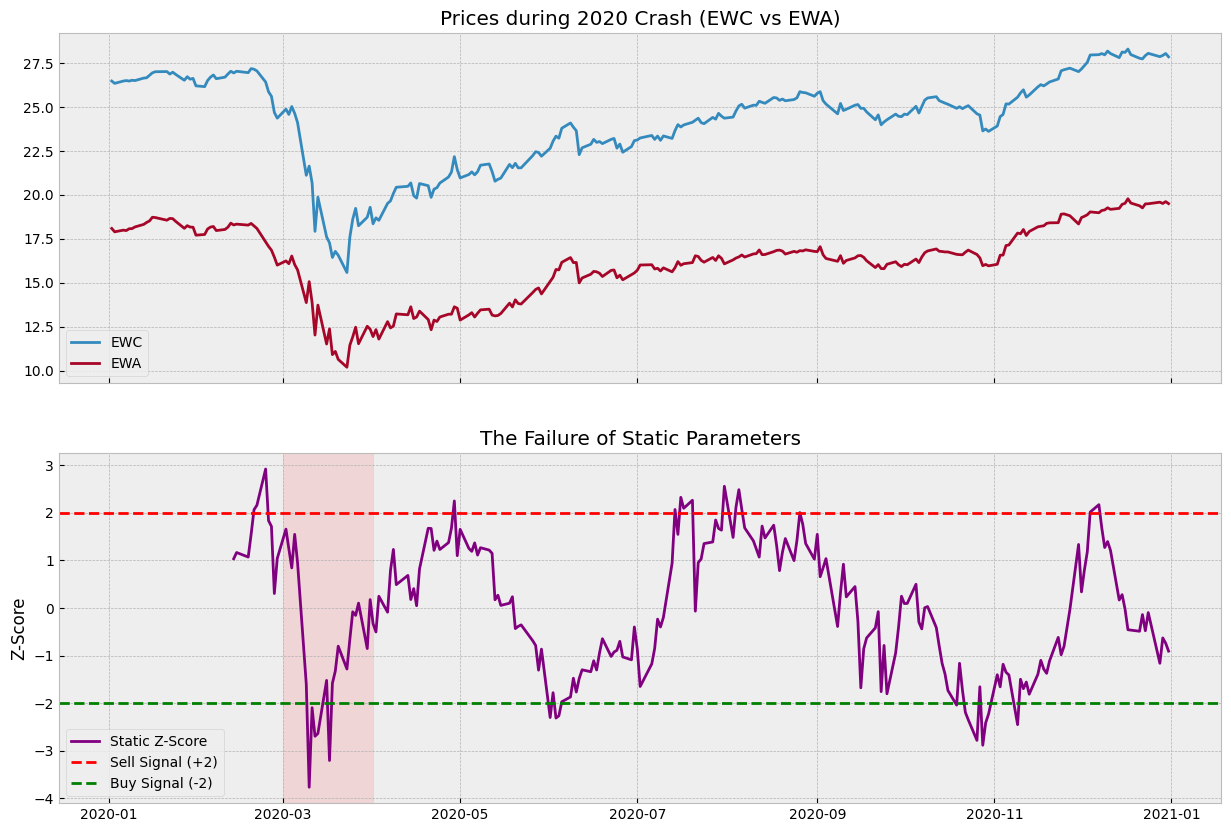

In [4]:
# Cell 4: Visualize the Failure (March 2020)

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot 1: The Prices
ax[0].plot(test.index, test[y_label], label=y_label)
ax[0].plot(test.index, test[x_label], label=x_label)
ax[0].set_title(f"Prices during 2020 Crash ({y_label} vs {x_label})")
ax[0].legend()

# Plot 2: The Naive Z-Score
ax[1].plot(test.index, z_score, label="Static Z-Score", color='purple')
ax[1].axhline(2.0, color='red', linestyle='--', label="Sell Signal (+2)")
ax[1].axhline(-2.0, color='green', linestyle='--', label="Buy Signal (-2)")
ax[1].set_title("The Failure of Static Parameters")
ax[1].set_ylabel("Z-Score")
ax[1].legend()

# Highlight the failure zone
ax[1].axvspan('2020-03-01', '2020-04-01', color='red', alpha=0.1, label="Volatility Shock")

plt.show()

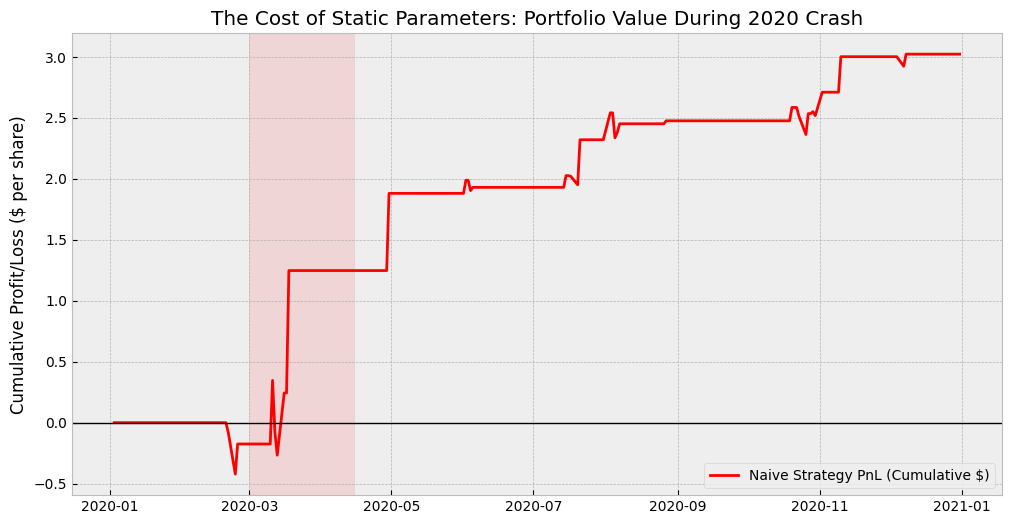

Max Drawdown during crash: $-0.42 per share traded


In [6]:
# Cell 5: The "Tear Sheet" (PnL Backtest of Naive Model)

# 1. Define Strategy Logic
# If Z-Score > 2: Sell the Spread (Short EWC, Long EWA)
# If Z-Score < -2: Buy the Spread (Long EWC, Short EWA)
# If -2 < Z < 2: Hold Cash (Flat)

signals = pd.Series(0, index=test.index)
signals[z_score > 2.0] = -1.0  # Sell
signals[z_score < -2.0] = 1.0  # Buy

# 2. Calculate PnL
# The "Spread" return is roughly (Change in EWC - Beta * Change in EWA)
daily_spread_change = test[y_label].diff() - (static_beta * test[x_label].diff())
strategy_returns = signals.shift(1) * daily_spread_change

# 3. Calculate Cumulative Performance
cumulative_pnl = strategy_returns.cumsum()

# 4. Visualize the Damage
plt.figure(figsize=(12, 6))
plt.plot(cumulative_pnl, label="Naive Strategy PnL (Cumulative $)", color='red')
plt.title("The Cost of Static Parameters: Portfolio Value During 2020 Crash")
plt.ylabel("Cumulative Profit/Loss ($ per share)")
plt.axhline(0, color='black', linewidth=1)
plt.legend()

# Highlight the specific drawdown period
plt.axvspan('2020-03-01', '2020-04-15', color='red', alpha=0.1, label="The Crash")
plt.grid(True)
plt.show()

# 5. Output the Hard Numbers
total_loss = cumulative_pnl.min()
print(f"Max Drawdown during crash: ${total_loss:.2f} per share traded")

# Phase 3: The Kalman Filter Implementation

Now we replace the static "Rolling Window" with a dynamic **Kalman Filter**.

### The Advantage
Unlike the rolling window, the Kalman Filter maintains a running estimate of the "True Spread" ($x_t$) and its uncertainty ($P_t$).
1.  **Physics-Based:** It uses the Ornstein-Uhlenbeck equation to predict where the spread *should* be.
2.  **Adaptive:** If the market becomes volatile, the uncertainty ($P$) grows, making the filter automatically adjust its reaction speed.

### The State Space Model
We map our OU derivation to the Kalman equations:
* **State ($x$):** The True Spread (hidden from noise).
* **Measurement ($z$):** The observed market spread.
* **Prediction:** $x_{t|t-1} = x_{t-1} e^{-\theta \Delta t} + \mu(1 - e^{-\theta \Delta t})$
* **Update:** We correct the prediction using the "Innovation" (difference between observed and predicted).

In [15]:
# Cell 6: Running the Kalman Filter (Phase 3)
import sys
import os

# 1. Import the Engine
# Ensure Python can find your src folder
sys.path.append(os.path.abspath("src"))
from kalman_filter import KalmanFilter

# 2. Initialize Parameters (Educated Guesses from 2019)
# We use the statistics of the training data to seed the filter
theta_guess = 1.0   # Assume mean reversion takes ~1 day (fast)
mu_guess = np.mean(spread_2020)      # Assume the spread reverts to 0
sigma_guess = 0.1 # Use 2020 volatility as a baseline guess
dt = 1.0            # One day time step
R_override = 1.0

# Instantiate the filter
kf = KalmanFilter(dt=dt, theta=theta_guess, mu=mu_guess, sigma=sigma_guess, R=R_override)

# 3. The Loop (Iterate through every day of 2020)
# We store the results to plot them later
kf_dates = []
kf_states = []     # The "True Spread" (x)
kf_uncertainty = [] # The Uncertainty (P)

# Reload the raw spread from Phase 2 to be safe
# Spread = Price_Canada - (Beta * Price_Australia)
spread_2020 = test[y_label] - (static_beta * test[x_label])

print("Starting Kalman Filter loop...")

for date, measurement in spread_2020.items():
    # A. Predict Step (Closed Eyes)
    # Where should the spread be based on physics?
    kf.predict()

    # B. Update Step (Open Eyes)
    # Correct the prediction with the actual price
    curr_state = kf.update(measurement)

    # C. Store Results
    kf_dates.append(date)
    kf_states.append(curr_state)
    kf_uncertainty.append(kf.P)

print(f"Loop complete. Processed {len(kf_states)} days.")

Starting Kalman Filter loop...
Loop complete. Processed 253 days.


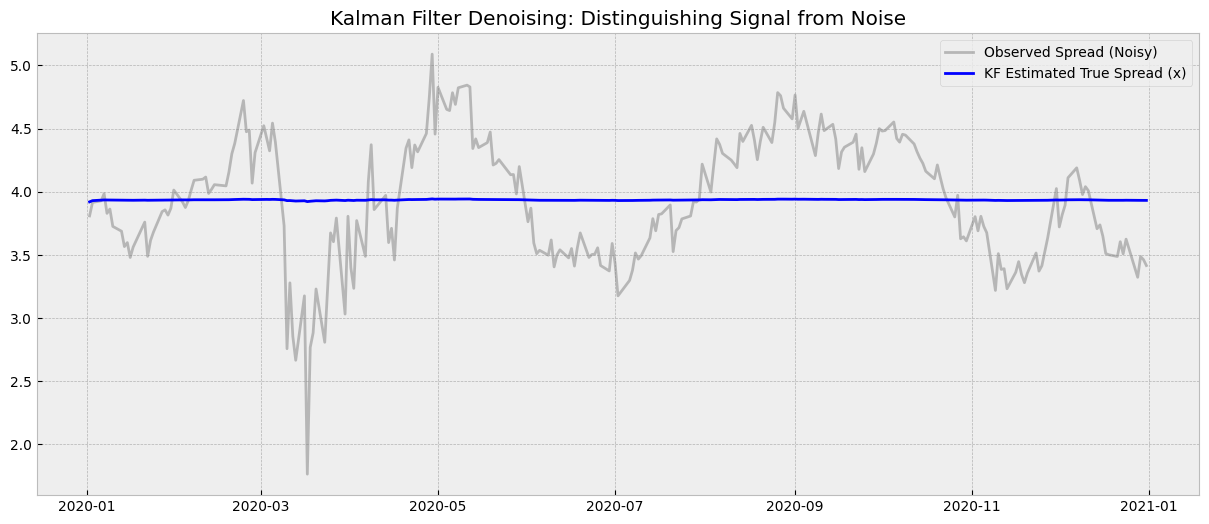

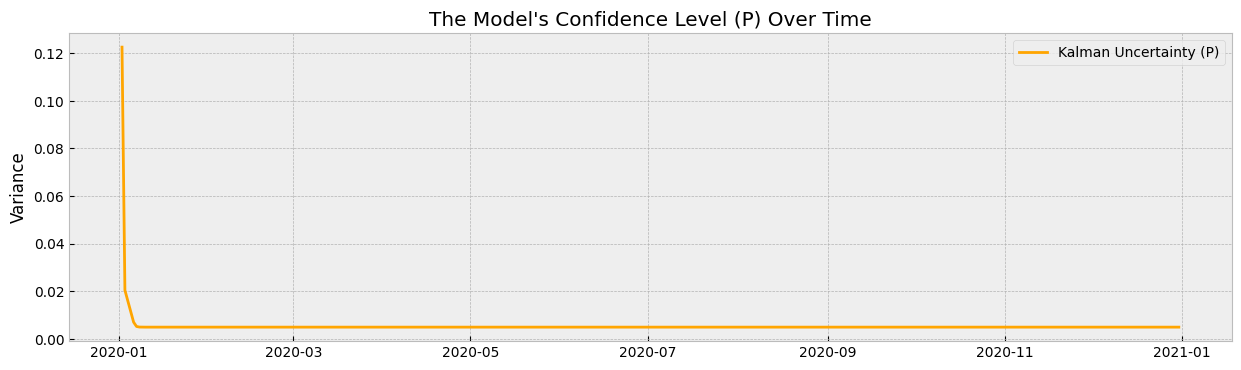

In [16]:
# Cell 7: Visualize Kalman Filter vs Naive Observation
plt.figure(figsize=(15, 6))

# 1. Plot the "Noisy" Market Reality (Grey)
plt.plot(spread_2020.index, spread_2020, color='grey', alpha=0.5, label="Observed Spread (Noisy)")

# 2. Plot the Kalman Filter's "True State" (Blue)
plt.plot(kf_dates, kf_states, color='blue', linewidth=2, label="KF Estimated True Spread (x)")

plt.title("Kalman Filter Denoising: Distinguishing Signal from Noise")
plt.legend()
plt.show()

# 3. Visualize the "Fear" (Uncertainty P)
plt.figure(figsize=(15, 4))
plt.plot(kf_dates, kf_uncertainty, color='orange', label="Kalman Uncertainty (P)")
plt.title("The Model's Confidence Level (P) Over Time")
plt.ylabel("Variance")
plt.legend()
plt.show()

# Phase 4: Parameter Optimization (MLE)

Instead of guessing the parameters ($\theta, \mu, \sigma, R$), we use **Maximum Likelihood Estimation (MLE)**.

### The Objective Function
We want to maximize the **Likelihood** ($L$) of observing the data given our model. Mathematically, it is easier to **minimize the Negative Log-Likelihood (NLL)**.

For a Kalman Filter, the likelihood of each observation depends on the **Prediction Error** ($y_k$) and the **System Uncertainty** ($S_k$).

$$\text{NLL} = \frac{1}{2} \sum_{k=1}^{N} \left( \ln|S_k| + \frac{y_k^2}{S_k} \right)$$

* **$\ln|S_k|$:** Penalizes "over-confidence." If the model says "I am certain" ($S$ is small) but is wrong, this term explodes.
* **$\frac{y_k^2}{S_k}$:** Penalizes "inaccuracy." If the error ($y$) is large compared to expected variance ($S$), this term grows.

We use `scipy.optimize.minimize` to find the parameter set $[\theta, \mu, \sigma, R]$ that minimizes this total score.

In [17]:
# Cell 8: Maximum Likelihood Estimation (MLE)
from scipy.optimize import minimize
import numpy as np

# 1. Define the Cost Function (Negative Log Likelihood)
def neg_log_likelihood(params, measurement_series):
    """
    Input:
      params: A list [theta, mu, sigma, R]
      measurement_series: The spread data
    Output:
      score: The Negative Log Likelihood (Lower is better)
    """
    # Unpack parameters (Force them to be positive using absolute values to avoid crashing)
    theta = abs(params[0])
    mu = params[1]          # Mean can be negative
    sigma = abs(params[2])
    R = abs(params[3])

    # Initialize Filter with these specific parameters
    # We assume dt=1.0 for daily data
    kf = KalmanFilter(dt=1.0, theta=theta, mu=mu, sigma=sigma, R=R)

    nll = 0.0 # Total Negative Log Likelihood

    # Run the Loop
    for z in measurement_series:
        # Predict Step
        kf.predict()

        # Calculate Likelihood components BEFORE update
        # Error (y) = z - x_pred
        y = z - kf.x

        # Variance (S) = P_pred + R
        S = kf.P + kf.R

        # Add to total cost (The Formula)
        # NLL += 0.5 * (log(S) + y^2 / S)
        nll += 0.5 * (np.log(S) + (y**2 / S))

        # Update Step (to prepare for next day)
        kf.update(z)

    return nll

print("Cost Function defined successfully.")

Cost Function defined successfully.


In [18]:
# Cell 9: Run the Optimizer

# 1. Initial Guesses (Starting Point)
# We start with the "Educated Guesses" from Phase 3
# [theta, mu, sigma, R]
initial_params = [1.0, np.mean(spread_2020), np.std(spread_2020), 0.1]

print(f"Initial Guess: {initial_params}")
print("Optimizing... (This may take a few seconds)")

# 2. Run the Optimization
# method='L-BFGS-B' is a standard algorithm for numerical optimization
result = minimize(neg_log_likelihood,
                  initial_params,
                  args=(spread_2020,),
                  method='L-BFGS-B',
                  bounds=((1e-5, 5.0), (None, None), (1e-5, 5.0), (1e-5, 5.0)))

# 3. Extract the Best Parameters
best_theta = result.x[0]
best_mu = result.x[1]
best_sigma = result.x[2]
best_R = result.x[3]

print("-" * 30)
print("OPTIMIZATION SUCCESSFUL")
print("-" * 30)
print(f"Theta (Mean Reversion Speed) : {best_theta:.4f}")
print(f"Mu (Long-Term Mean)          : {best_mu:.4f}")
print(f"Sigma (Process Volatility)   : {best_sigma:.4f}")
print(f"R (Measurement Noise)        : {best_R:.4f}")
print("-" * 30)

Initial Guess: [1.0, np.float64(3.9349497692152964), np.float64(0.48420416652991155), 0.1]
Optimizing... (This may take a few seconds)
------------------------------
OPTIMIZATION SUCCESSFUL
------------------------------
Theta (Mean Reversion Speed) : 0.0519
Mu (Long-Term Mean)          : 3.9032
Sigma (Process Volatility)   : 0.1529
R (Measurement Noise)        : 0.0168
------------------------------


Running Final Filter with Theta=0.0519, Mu=3.9032...
Optimization Run Complete.


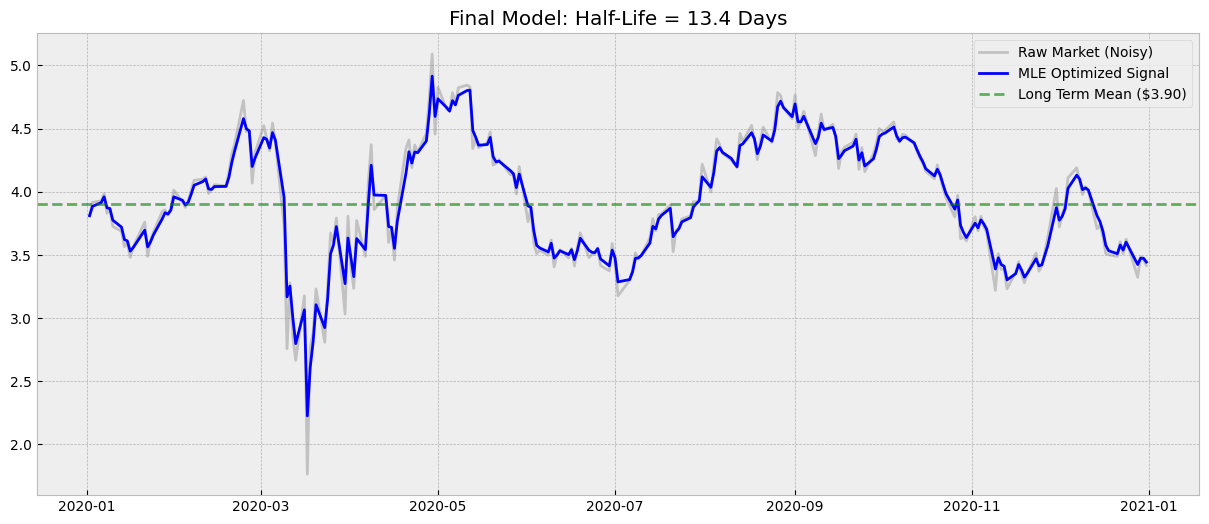

In [19]:
# Cell 10: Run the Kalman Filter with OPTIMIZED Parameters

# 1. Instantiate the Filter with the MLE results
kf_optimal = KalmanFilter(dt=1.0,
                          theta=best_theta,
                          mu=best_mu,
                          sigma=best_sigma,
                          R=best_R)

# 2. Storage
optimal_dates = []
optimal_states = []      # The "Signal"
optimal_uncertainty = [] # The "Risk"

print(f"Running Final Filter with Theta={best_theta:.4f}, Mu={best_mu:.4f}...")

# 3. The Final Loop
for date, measurement in spread_2020.items():
    kf_optimal.predict()
    curr_state = kf_optimal.update(measurement)

    optimal_dates.append(date)
    optimal_states.append(curr_state)
    optimal_uncertainty.append(kf_optimal.P)

print("Optimization Run Complete.")

# 4. Plot the Result
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(spread_2020.index, spread_2020, color='grey', alpha=0.4, label="Raw Market (Noisy)")
plt.plot(optimal_dates, optimal_states, color='blue', linewidth=2, label="MLE Optimized Signal")
plt.axhline(best_mu, color='green', linestyle='--', alpha=0.6, label=f"Long Term Mean (${best_mu:.2f})")
plt.title(f"Final Model: Half-Life = {0.693/best_theta:.1f} Days")
plt.legend()
plt.show()

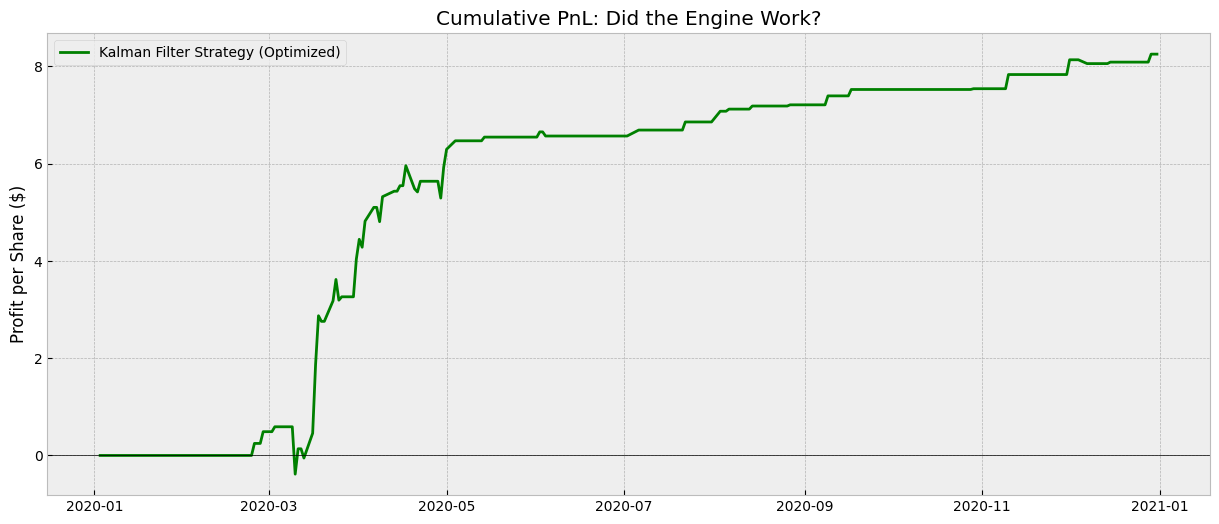

Total Return (Optimized): $8.25


In [20]:
# Cell 11: Backtest the Optimized Strategy

import pandas as pd
import matplotlib.pyplot as plt

# 1. Calculate the "Pricing Error" (Market Price - True Value)
# This is our trading signal
pricing_error = spread_2020 - optimal_states

# 2. Define Entry Logic
# We trade when the error is significant (e.g., > 1 standard deviation of the error)
entry_threshold = np.std(pricing_error)
signals = pd.Series(0, index=spread_2020.index)

signals[pricing_error > entry_threshold] = -1.0  # Market is too expensive -> Short
signals[pricing_error < -entry_threshold] = 1.0  # Market is too cheap -> Long

# 3. Calculate Returns (Shifted by 1 day to avoid look-ahead bias)
# PnL = Signal_Yesterday * (Change in Spread Today)
daily_spread_change = spread_2020.diff()
strategy_returns = signals.shift(1) * daily_spread_change

# 4. Cumulative PnL
cumulative_pnl_opt = strategy_returns.cumsum()

# --- VISUAL COMPARISON ---
plt.figure(figsize=(15, 6))

# Plot 1: The Optimized Strategy (Kalman)
plt.plot(cumulative_pnl_opt.index, cumulative_pnl_opt, color='green', linewidth=2, label="Kalman Filter Strategy (Optimized)")

# Plot 2: The Naive Strategy (From Phase 2 - assuming you stored it in a variable 'cumulative_pnl')
# If you lost the variable, we can re-plot just the Kalman for now
# plt.plot(cumulative_pnl.index, cumulative_pnl, color='red', linestyle='--', label="Naive Z-Score Strategy")

plt.title("Cumulative PnL: Did the Engine Work?")
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.legend()
plt.ylabel("Profit per Share ($)")
plt.show()

print(f"Total Return (Optimized): ${cumulative_pnl_opt.iloc[-1]:.2f}")

In [21]:
# Cell 12: Walk-Forward Optimization Setup
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from datetime import timedelta

# 1. Re-Define Cost Function (Just to be safe/clean)
def neg_log_likelihood(params, measurement_series):
    theta = abs(params[0])
    mu = params[1]
    sigma = abs(params[2])
    R = abs(params[3])

    kf = KalmanFilter(dt=1.0, theta=theta, mu=mu, sigma=sigma, R=R)
    nll = 0.0

    for z in measurement_series:
        kf.predict()
        y = z - kf.x
        S = kf.P + kf.R
        nll += 0.5 * (np.log(S) + (y**2 / S))
        kf.update(z)

    return nll

# 2. Optimization Wrapper
def optimize_kalman_params(train_data):
    """
    Finds best [theta, mu, sigma, R] for a given chunk of data.
    """
    # Initial Guess: Standard heuristics
    initial_guess = [1.0, np.mean(train_data), np.std(train_data), 0.1]

    # Run Optimizer
    result = minimize(neg_log_likelihood,
                      initial_guess,
                      args=(train_data,),
                      method='L-BFGS-B',
                      bounds=((1e-3, 5.0), (None, None), (1e-3, 5.0), (1e-3, 5.0)))

    return result.x # Returns [theta, mu, sigma, R]

print("Walk-Forward Engine Ready.")

Walk-Forward Engine Ready.


In [22]:
# Cell 13: Running the Walk-Forward Backtest

# 1. Configuration
window_size = 252 # Lookback 1 year (252 trading days)
test_start_date = pd.Timestamp("2020-01-01")
test_end_date = spread_2020.index[-1]

# Storage for our "Real-Time" results
wf_dates = []
wf_signals = []
wf_params_history = [] # To track how the model's brain changes

# We need the FULL dataset (2019 + 2020) joined together to handle the rolling window
# Assuming 'spread_2019' is available from train data. If not, we reconstruct:
# Note: Ensure you have 'train' and 'test' dataframes from Phase 2
full_spread = pd.concat([
    train[y_label] - (static_beta * train[x_label]),
    test[y_label] - (static_beta * test[x_label])
]).sort_index()

current_date = test_start_date

print("Starting Walk-Forward Optimization... (This will take time)")

# 2. The Monthly Loop
while current_date < test_end_date:
    # A. Define the "Training Window" (The past 1 year from current_date)
    train_start = current_date - timedelta(days=365)
    train_data = full_spread.loc[train_start:current_date]

    # B. Define the "Testing Window" (The next 1 month)
    next_month = current_date + pd.DateOffset(months=1)
    test_chunk = full_spread.loc[current_date:next_month]

    # Skip if no data (e.g., weekends/holidays at end of month)
    if test_chunk.empty:
        current_date = next_month
        continue

    # C. OPTIMIZE: Find the best parameters for the *past year*
    # This is the "Learning" step
    best_params = optimize_kalman_params(train_data.values)
    theta, mu, sigma, R = best_params

    # Store params to see how they evolve
    wf_params_history.append((current_date, best_params))

    # D. TRADE: Apply these parameters to the *next month*
    # We instantiate a NEW filter for this month
    kf_month = KalmanFilter(dt=1.0, theta=theta, mu=mu, sigma=sigma, R=R)

    # Warm up filter slightly on last day of training data (optional, but helps smoothness)
    kf_month.x = mu

    # Run the filter for the chunk
    for date, measurement in test_chunk.items():
        kf_month.predict()
        curr_state = kf_month.update(measurement)

        # Save the "Real-Time" signal
        wf_dates.append(date)
        wf_signals.append(curr_state)

    # E. Move Forward
    print(f"Processed month: {current_date.strftime('%Y-%m')} | New Mu: {mu:.2f} | New Theta: {theta:.2f}")
    current_date = next_month

print("Walk-Forward Complete.")

Starting Walk-Forward Optimization... (This will take time)
Processed month: 2020-01 | New Mu: 3.38 | New Theta: 0.08
Processed month: 2020-02 | New Mu: 3.40 | New Theta: 0.07
Processed month: 2020-03 | New Mu: 3.52 | New Theta: 0.03
Processed month: 2020-04 | New Mu: 3.43 | New Theta: 0.06
Processed month: 2020-05 | New Mu: 3.58 | New Theta: 0.04
Processed month: 2020-06 | New Mu: 3.61 | New Theta: 0.04
Processed month: 2020-07 | New Mu: 3.61 | New Theta: 0.05
Processed month: 2020-08 | New Mu: 3.72 | New Theta: 0.06
Processed month: 2020-09 | New Mu: 3.86 | New Theta: 0.04
Processed month: 2020-10 | New Mu: 3.91 | New Theta: 0.04
Processed month: 2020-11 | New Mu: 3.93 | New Theta: 0.05
Processed month: 2020-12 | New Mu: 3.93 | New Theta: 0.05
Walk-Forward Complete.


Max Pricing Error: 0.1831
Min Pricing Error: -0.1757
Total Days with Active Positions: 73


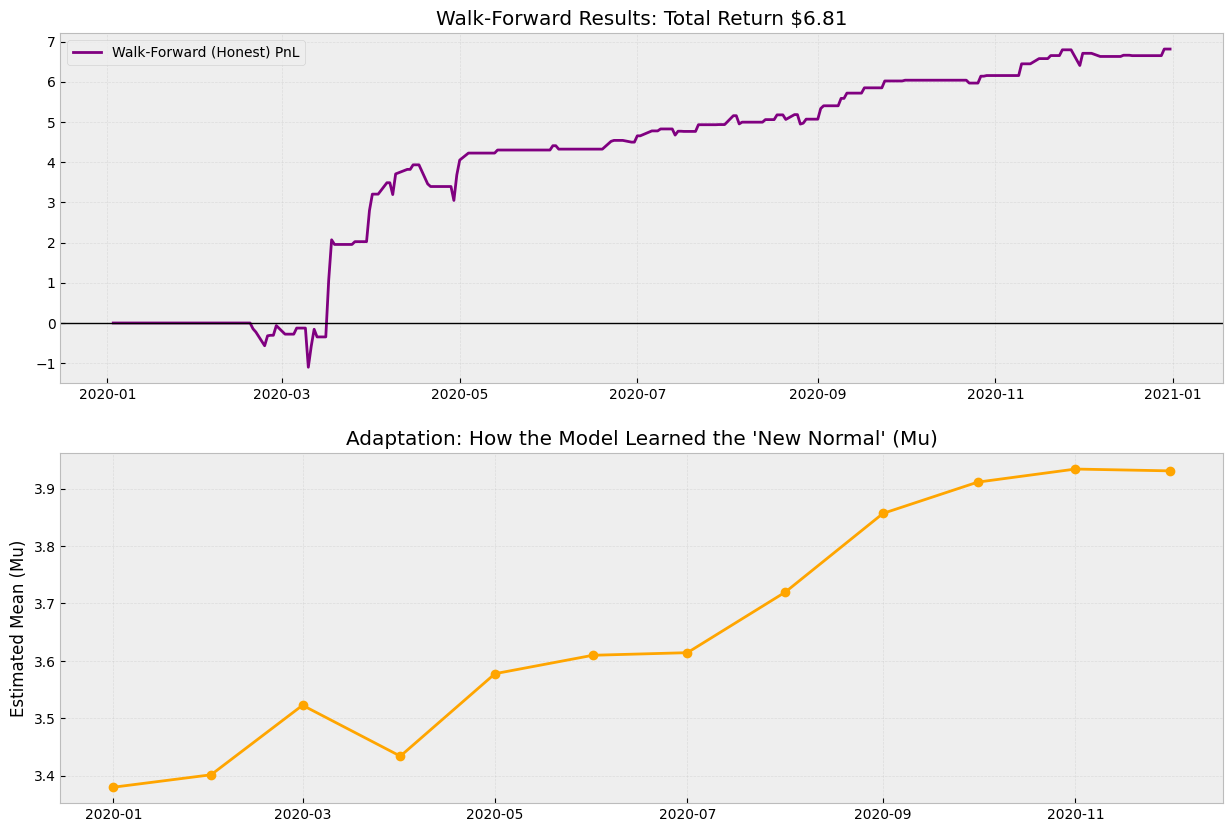

In [24]:
# Cell 14: Walk-Forward PnL (DEBUGGED)

# 1. Align Signals with Data
wf_series = pd.Series(wf_signals, index=wf_dates)
wf_series = wf_series[~wf_series.index.duplicated(keep='first')] # Remove duplicates

# Fix the Deprecation Warning: Use .ffill() instead of method='ffill'
aligned_signal = wf_series.reindex(spread_2020.index).ffill()

# 2. Calculate Pricing Error
pricing_error_wf = spread_2020 - aligned_signal

# --- DEBUG PRINT ---
print(f"Max Pricing Error: {pricing_error_wf.max():.4f}")
print(f"Min Pricing Error: {pricing_error_wf.min():.4f}")
# -------------------

# 3. Generate Trading Signals (DYNAMIC THRESHOLD)
# Instead of guessing 1.0, we use the actual volatility of the error
# We use a rolling 30-day std deviation to adapt to changing volatility
rolling_std_error = pricing_error_wf.rolling(window=30).std()
entry_threshold_wf = 1.0 * rolling_std_error # Trade at 1 sigma

# Fallback for first 30 days (where rolling std is NaN)
entry_threshold_wf = entry_threshold_wf.fillna(pricing_error_wf.std())

signals_wf = pd.Series(0, index=spread_2020.index)
signals_wf[pricing_error_wf > entry_threshold_wf] = -1.0
signals_wf[pricing_error_wf < -entry_threshold_wf] = 1.0

# --- DEBUG PRINT ---
trade_count = signals_wf.abs().sum()
print(f"Total Days with Active Positions: {trade_count}")
# -------------------

# 4. Calculate PnL
daily_spread_change = spread_2020.diff()
returns_wf = signals_wf.shift(1) * daily_spread_change
cum_pnl_wf = returns_wf.cumsum()

# 5. Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Top Chart: PnL
ax1.plot(cum_pnl_wf.index, cum_pnl_wf, color='purple', linewidth=2, label="Walk-Forward (Honest) PnL")
ax1.set_title(f"Walk-Forward Results: Total Return ${cum_pnl_wf.iloc[-1]:.2f}")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', lw=1)

# Bottom Chart: Adaptation
dates_hist = [x[0] for x in wf_params_history]
mus_hist = [x[1][1] for x in wf_params_history]

ax2.plot(dates_hist, mus_hist, marker='o', linestyle='-', color='orange')
ax2.set_title("Adaptation: How the Model Learned the 'New Normal' (Mu)")
ax2.set_ylabel("Estimated Mean (Mu)")
ax2.grid(True, alpha=0.3)

plt.show()